# Import section

In [1]:
%matplotlib inline

# Helper funcitons and classes
from helper_func_and_classes import create_dataset_list, create_submission_file, create_vocab
from helper_func_and_classes import split_dataset
from helper_func_and_classes import word_vec_to_word_embeddings
from helper_func_and_classes import word_vec_to_aggregated_word_embeddings
from helper_func_and_classes import word_embeddings_extraction
from helper_func_and_classes import TwitterDataset
from helper_func_and_classes import get_count_of_longest_sentence
from helper_func_and_classes import current_batch_train
from helper_func_and_classes import batch_sized_linear_model

# word embeddings
from torchtext.vocab import GloVe

# scikit-learn
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report


# plotting 
import matplotlib.pyplot as plt

import numpy as np

# random state
RANDOM_SEED = 123 # used in helper functions

# Section 1: Data preprocessing section

This section will extract the data from the three different .txt files. Then, the helper functions will process the tweets to create our vocabulary and three python lists for positive, negative, and submission tweets. The tweets are pre tokenized, so we only split on white space.

In [3]:
# creating the text vocabulary from the whole data set, including positive, negative and test data.
text_vocab_full = create_vocab("./twitter-datasets/train_pos_full.txt",
                          "./twitter-datasets/train_neg_full.txt",
                          "./twitter-datasets/test_data.txt")

text_vocab_lite = create_vocab("./twitter-datasets/train_pos.txt",
                          "./twitter-datasets/train_neg.txt",
                          "./twitter-datasets/test_data.txt")

# creating a standard python library list of positive tweets, 1 tweet per index
pos_data_full = create_dataset_list("./twitter-datasets/train_pos_full.txt")
pos_data_lite = create_dataset_list("./twitter-datasets/train_pos.txt")

# creating a standard python library list of negative tweets, 1 tweet per index
neg_data_full = create_dataset_list("./twitter-datasets/train_neg_full.txt")
neg_data_lite = create_dataset_list("./twitter-datasets/train_neg.txt")


# creating a standard python library list of the tweets that will be used for submission, 1 tweet per index
submission_data = create_dataset_list("./twitter-datasets/test_data.txt")

print("Length of text_vocab_full: ", len(text_vocab_full))
print("Length of text_vocab_lite: ", len(text_vocab_lite))
print("Length of submission_data: ",len(submission_data))

100%|█████████████████████████████████████████| 10000/10000 [00:00<00:00, 800714.75it/s]


Length of text_vocab_full:  604014
Length of text_vocab_lite:  127802
Length of submission_data:  10000


Here we will create the TwitterDataset class which contains all the pre processed data, we have done a sentence cutoff for the sentences longe than 37, this was found in the exploratory data analysis part.

In [4]:
# Creating the dataset in the TwitterDataset class which is found in the helper functions
dataset_full = TwitterDataset(text_vocab_full, pos_data_full, neg_data_full, submission_data, 37)
dataset_lite = TwitterDataset(text_vocab_lite, pos_data_lite, neg_data_lite, submission_data, 37)

100%|███████████████████████████████████████| 100000/100000 [00:00<00:00, 207854.28it/s]


Here we split and shuffle the dataset into training and testing. The longest sentences is also located by using the get_count_of_longest_sentence on the dataset.

In [5]:
# create training dataset and test dataset - using a split of 85% / 15%
train_dataset_full, test_dataset_full = split_dataset(dataset_full, 0.9);
train_dataset_lite, test_dataset_lite = split_dataset(dataset_lite, 0.9);

# calculating the longest sentence
max_len_full = get_count_of_longest_sentence(dataset_full)
max_len_lite = get_count_of_longest_sentence(dataset_lite)

Number of elements in train_data is:  2246870
Number of elements in test_data is:  249653
Number of elements in train_data is:  179784
Number of elements in test_data is:  19976


<br/><br/>
# Section 2: SGDClassifier
### loss='log' | Pretrained word embeddings (dim=25)
Here we will use pre-trained Global Vector word embeddings (Glove); these will have a dimension of 25 per word. The pre-trained word embeddings were downloaded from https://pytorch.org/text/stable/_modules/torchtext/vocab/vectors.html#GloVe. The word embedding used has been trained on Twitter data, which will increase accuracy since our corpus also consists of Twitter data.

In [6]:
glove_vec = GloVe(name='twitter.27B', dim=25)
word_embeddings_full = glove_vec.get_vecs_by_tokens(list(text_vocab_full.keys()), lower_case_backup=True)
word_embeddings_lite = glove_vec.get_vecs_by_tokens(list(text_vocab_lite.keys()), lower_case_backup=True)

## Section 2.1: Choosing best parameters
Here we will train the linear model with a batch size of 200 000 tweets per iteration. It is not possible to take in the whole dataset and transfer it to its corresponding word embedding since each vector is huge. This code will therefore take in 200 000 quotes at a time, transfer them into word embedding and then train on that part alone.  

First and foremost we will ned to optimize the learning rate for the SGD classifier, this will be done on the dataset_lite.

In [11]:
dimension = 25
vec_size_lite = max_len_lite # Maximum sentences length in the whole dataset
alpha_val_list = [1e-3, 2.5e-3, 4e-3, 5e-3, 7.5e-3, 1e-2, 2.5e-2, 3.5e-2, 5e-2] # different learning rates

precision_list = []
recall_list = []
f1score_list = []
support_list = []

for alpha_val in alpha_val_list:
    print("Alpha value of: ", alpha_val)
    lr_model = batch_sized_linear_model(200000, train_dataset_lite, word_embeddings_lite, vec_size_lite, dimension, alpha_val)

    
    X_test, y_test = word_vec_to_word_embeddings(test_dataset_lite, word_embeddings_lite, vec_size_lite, dimension)
    y_prediction = lr_model.predict(X_test)
    
    #precision, recall, f1score, support = classification_report(y_test, y_prediction, output_dict=True)
    class_report = classification_report(y_test, y_prediction, output_dict=True)['macro avg']
    print(class_report, "\n")
    
    # appending results to corresponding list
    precision_list.append(class_report['precision'])
    recall_list.append(class_report['recall'])
    f1score_list.append(class_report['f1-score'])
    support_list.append(class_report['support'])

Alpha value of:  0.001


19976it [00:00, 21296.97it/s]


{'precision': 0.6700094235699046, 'recall': 0.6646475278109242, 'f1-score': 0.6618136636375992, 'support': 19976} 

Alpha value of:  0.0025


19976it [00:01, 19837.10it/s]


{'precision': 0.6944819621406487, 'recall': 0.6938545315447092, 'f1-score': 0.693660023031696, 'support': 19976} 

Alpha value of:  0.004


19976it [00:00, 20294.89it/s]


{'precision': 0.7073673926647653, 'recall': 0.7005891377009636, 'f1-score': 0.6982979299631805, 'support': 19976} 

Alpha value of:  0.005


19976it [00:00, 20254.13it/s]


{'precision': 0.7115361355298837, 'recall': 0.7014882212556295, 'f1-score': 0.698113883421323, 'support': 19976} 

Alpha value of:  0.0075


19976it [00:00, 20272.82it/s]


{'precision': 0.7137273694799546, 'recall': 0.6983642236678342, 'f1-score': 0.6931069671677701, 'support': 19976} 

Alpha value of:  0.01


19976it [00:00, 20429.91it/s]


{'precision': 0.7127256765563685, 'recall': 0.6955888650448439, 'f1-score': 0.6896093891542714, 'support': 19976} 

Alpha value of:  0.025


19976it [00:00, 20879.76it/s]


{'precision': 0.708168483251348, 'recall': 0.6914342674211222, 'f1-score': 0.6853810854732143, 'support': 19976} 

Alpha value of:  0.035


19976it [00:00, 20907.71it/s]


{'precision': 0.707614718815498, 'recall': 0.6912884364935781, 'f1-score': 0.685369725629907, 'support': 19976} 

Alpha value of:  0.05


19976it [00:00, 20951.30it/s]


{'precision': 0.7040014139394347, 'recall': 0.6887957982088097, 'f1-score': 0.6831503144314133, 'support': 19976} 



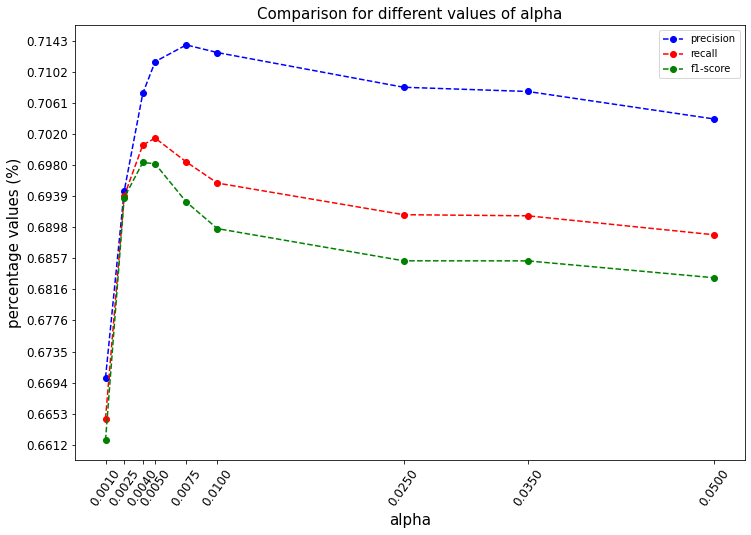

In [12]:
plt.rcParams["figure.figsize"] = (12,8)
plt.xticks(alpha_val_list, rotation='55', fontsize=12)
plt.yticks(np.linspace(0.6,0.8, 50), fontsize=12)
plt.plot(alpha_val_list, precision_list, linestyle='--', marker='o', color='blue', label='precision')
plt.plot(alpha_val_list, recall_list, linestyle='--', marker='o', color='red', label='recall')
plt.plot(alpha_val_list, f1score_list, linestyle='--', marker='o', color='green', label='f1-score')
#plt.plot(alpha_val_list, support_list, color='orange', label='support')

plt.title("Comparison for different values of alpha", fontsize=15)
plt.xlabel("alpha", fontsize=15)
plt.ylabel("percentage values (%)", fontsize=15)


plt.legend();

## Section 2.2: Training the SGD classifier
Using the best alpha value found in the last parameters optmization. The best value for the `alpha_val == 0.005`. This value is a combination of the precision, recall, and f1-score (which includes both recall and precision weighted half each).

With this value we will train the SGD classifier on the full dataset and craete a classification report to see how the model perfomed.

In [13]:
dimension = 25
vec_size_full = max_len_full
best_alpha = 0.005

lr_model = batch_sized_linear_model(200000, train_dataset_full, word_embeddings_full, vec_size_full, dimension, best_alpha)

X_test, y_test = word_vec_to_word_embeddings(test_dataset_full, word_embeddings_full, vec_size_full, dimension)
y_prediction = lr_model.predict(X_test)

print(classification_report(y_test, y_prediction, digits=4))

249653it [00:11, 21176.13it/s]


              precision    recall  f1-score   support

         0.0     0.7323    0.6510    0.6892    124773
         1.0     0.6861    0.7622    0.7221    124880

    accuracy                         0.7066    249653
   macro avg     0.7092    0.7066    0.7057    249653
weighted avg     0.7092    0.7066    0.7057    249653



**Comments on the results from this model:**
1. The vector is probably to big for the amount of data we have to train on.
2. The vectors will tend to be sparse since a lot of them will be fitted with extra zeros to compensate for not having a long enough sentence.

# Section 3: Creating submission

In [14]:
submission_matrix_25_lr, id_submission_matrix_25_lr = word_vec_to_word_embeddings(
    dataset_full.submission_dataset,
    word_embeddings_full,
    vec_size_full,
    dimension)

10000it [00:00, 20672.38it/s]


In [ ]:
submission_prediction_25_lr = lr_model.predict(submission_matrix_25_lr)

In [ ]:
create_submission_file(submission_prediction_25_lr)